In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

random_state = 52

%matplotlib inline

sns.set(style='darkgrid')

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


Посмотрим сначала на значения целевой переменной.

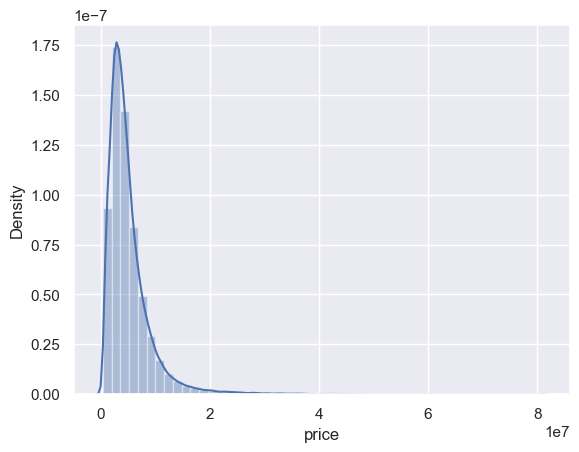

In [3]:
sns.distplot(df['price']);

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью.

Преобразуем дату в 2 колонки: год и месяц.

In [4]:
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df.drop('date', axis=1, inplace=True)

Разделим данные на обучающую и тестовую выборки.

In [5]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.25)

Посмотрим на коэффициент корреляции Пирсона между признаками и целевой переменной.

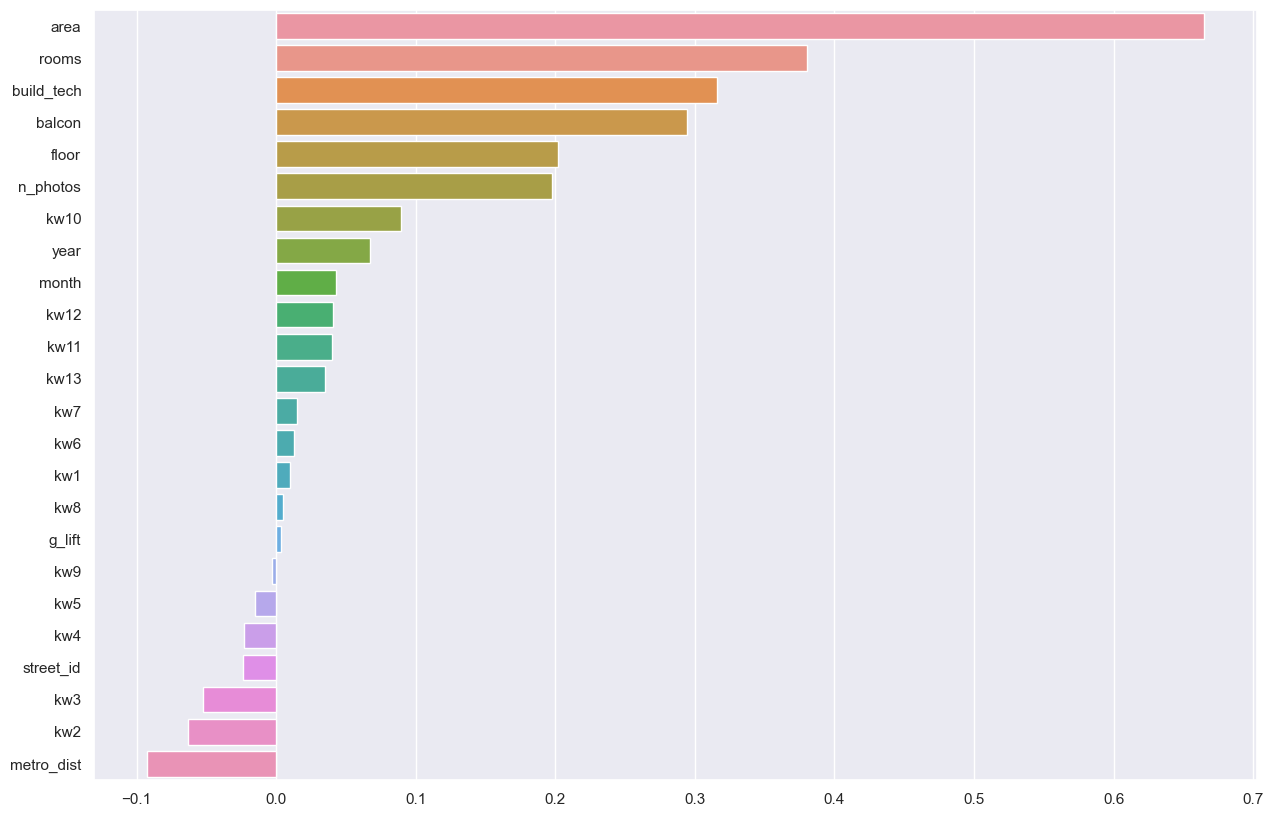

In [6]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train_n = X_train.fillna(numeric_data_mean)
X_test_n = X_test.fillna(numeric_data_mean)

correlations = X_train_n[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков.

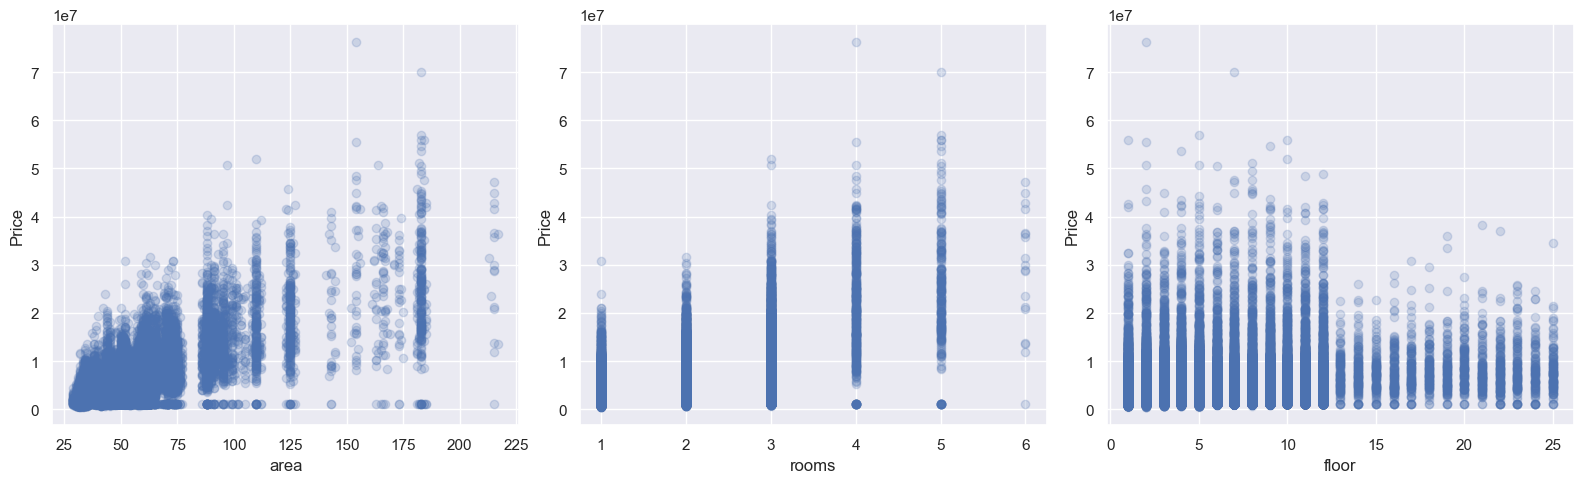

In [7]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['area', 'rooms', 'floor']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Price')
plt.tight_layout()

Будем масштабировать наши признаки перед обучением модели. 

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

y_train = np.log(y_train)
y_val = np.log(y_val)

In [9]:
train_pool = Pool(data=X_train_scaled, label=y_train)
val_pool = Pool(data=X_val_scaled, label=y_val)
test_pool = Pool(data=X_test_scaled, label=y_test)

Прологорифмируем y, чтобы привести распределение к нормальному виду.

In [10]:
model = CatBoostRegressor(learning_rate=0.13, random_seed=42, iterations=15000, loss_function='MAE')
    
model.fit(train_pool, eval_set=val_pool, verbose=3000, use_best_model=True, plot='True')
y_pred = np.exp(model.predict(test_pool))

print(f'Test MAE = {mean_absolute_error(y_test, y_pred):.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5070702	test: 0.5086399	best: 0.5086399 (0)	total: 76.8ms	remaining: 19m 11s
3000:	learn: 0.2537881	test: 0.2918694	best: 0.2918364 (2972)	total: 19.6s	remaining: 1m 18s
6000:	learn: 0.2418425	test: 0.2892445	best: 0.2892007 (5926)	total: 39.9s	remaining: 59.9s
9000:	learn: 0.2357343	test: 0.2886541	best: 0.2885820 (8700)	total: 1m 1s	remaining: 40.9s
12000:	learn: 0.2319278	test: 0.2883260	best: 0.2883260 (12000)	total: 1m 23s	remaining: 20.9s
14999:	learn: 0.2290611	test: 0.2883167	best: 0.2882436 (14320)	total: 1m 47s	remaining: 0us

bestTest = 0.2882436302
bestIteration = 14320

Shrink model to first 14321 iterations.
Test MAE = 1340605.2195


Нарисуем гистограмму распределения ошибки на обучающих объектах:

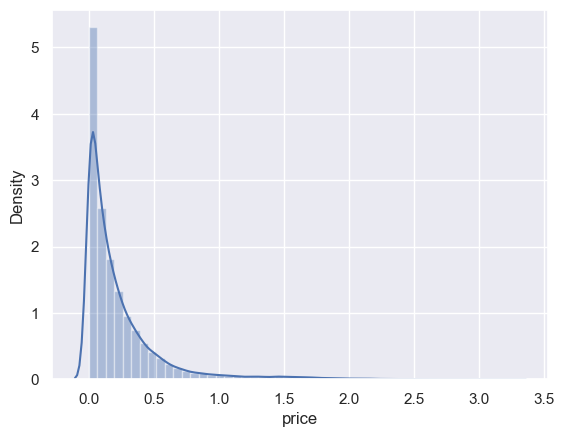

In [31]:
error = abs(y_train - model.predict(train_pool))
sns.distplot(error);

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [32]:
mask = (error < np.quantile(error, 0.95))
train_pool1 = Pool(data=X_train_scaled[mask], label=y_train[mask])
val_pool1 = Pool(data=X_val_scaled, label=y_val)
test_pool1 = Pool(data=X_test_scaled, label=y_test)

In [35]:
model = CatBoostRegressor(learning_rate=0.15, random_seed=42, iterations=15000, eval_metric='MAE', loss_function='MAE')
    
model.fit(train_pool1, eval_set=val_pool1, verbose=3000, use_best_model=True, plot='True')
y_pred = np.exp(model.predict(test_pool1))

print(f'Test MAE = {mean_absolute_error(y_test, y_pred):.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4638446	test: 0.5050348	best: 0.5050348 (0)	total: 6.71ms	remaining: 1m 40s
3000:	learn: 0.1939640	test: 0.2875773	best: 0.2875773 (3000)	total: 20.4s	remaining: 1m 21s
6000:	learn: 0.1835490	test: 0.2857600	best: 0.2857473 (5973)	total: 42s	remaining: 1m 2s
9000:	learn: 0.1782198	test: 0.2852735	best: 0.2852663 (8954)	total: 1m 3s	remaining: 42.6s
12000:	learn: 0.1747479	test: 0.2847574	best: 0.2847554 (11992)	total: 1m 26s	remaining: 21.7s
14999:	learn: 0.1721434	test: 0.2846644	best: 0.2846547 (14881)	total: 1m 50s	remaining: 0us

bestTest = 0.2846546844
bestIteration = 14881

Shrink model to first 14882 iterations.
Test MAE = 1330194.6242


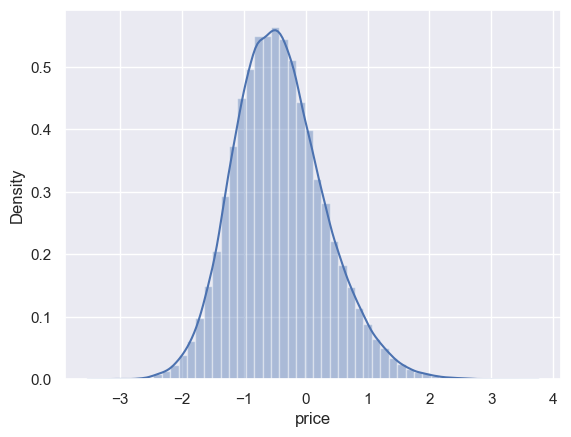

In [39]:
error = (y_train[mask] - model.predict(X_train[mask]))
sns.distplot(error);

Видим, что качество модели улучшилось.

In [40]:
test_df = pd.read_csv('test.csv')
id = test_df['id']
test_df.drop(columns=['id'], inplace=True)

test_df['year'] = test_df['date'].apply(lambda x: int(x.split('-')[0]))
test_df['month'] = test_df['date'].apply(lambda x: int(x.split('-')[1]))
test_df.drop('date', axis=1, inplace=True)

test_df.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month
0,459,NaN,1,60,3,1,30.0,0.0,4,0,...,0,0,0,0,0,0,0,0,2012,3
1,344,1.0,10,52,2,1,NaN,NaN,4,0,...,0,0,0,0,0,0,0,0,2012,3
2,585,0.0,4,54,3,0,30.0,0.0,0,0,...,0,0,0,0,0,0,0,0,2012,3
3,494,NaN,2,52,2,1,25.0,1.0,3,0,...,0,0,0,0,0,0,0,0,2012,3
4,622,1.0,9,60,3,1,15.0,NaN,1,1,...,0,0,0,0,0,0,0,0,2012,3


In [41]:
test_df_pool = Pool(data=test_df)
test_df['price'] = model.predict(test_df_pool)

test_df = pd.merge(test_df, id, left_index=True, right_index=True)
test_df[['id', 'price']].to_csv('test_pred.csv', index=False)

!cat test_pred.csv | head

id,price
100000,15.685345208896411
100001,15.125005388917106
100002,15.927805613437938
100003,16.258780459258983
100004,15.883842092735785
100005,15.941603562454585
100006,16.129270698044856
100007,16.105730045293562
100008,16.214145473099055
cat: stdout: Broken pipe
